In [228]:
# Packages for analysis
import pandas as pd
import numpy as np
from numpy import dtype
from netCDF4 import Dataset,date2num,num2date
from datetime import datetime

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def remove_noises(self): #Step 3-A
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises'],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def SHY95_algorithm(self,Zh):
        Zh.mask=0
        SHY95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        SHY95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 43.43) and (deltaZh >= (10-Zbg**2/180)):
                        SHY95[xo,yo]=1
                    elif Zbg>=43.43 and deltaZh>=0:
                        SHY95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    SHY95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and SHY95[q,l] !=2:
                    SHY95[q,l]=1
        return SHY95
    def create_nc(self, fileout, SHY95, grid):
        format_string_time = "%Y-%m-%dT%H:%M"
        ti=self.radar.time['units'][14:-4]
        format_time=datetime.strptime(ti, format_string_time)
        file = Dataset(fileout,'w')
        file.title = "SHY95 Algorithm files - netCDF "
        file.createDimension('longitude',self.shape_grid[2])
        file.createDimension('latitude',self.shape_grid[1])
        file.createDimension('time',1)
        times = file.createVariable('time',dtype('i8').char,('time',))
        lons = file.createVariable('longitude',dtype('f4').char,('longitude',))
        lats = file.createVariable('latitude',dtype('f4').char,('latitude',))
        lats.units = 'degrees_north'
        lats.standard_name = "Latitude"
        lats.long_name = "Latitude"
        lats.axis = "Y"
        lons.standard_name = "Longitude"
        lons.long_name = "Longitude"
        lons.axis = "X"
        lons.units = 'degrees_east'
        times.units = "minutes since 0001-01-01 00:00"
        times.calendar = "gregorian"
        times.standard_name = "time"
        times.axis = "T"
        lons[:] = grid.x["data"]
        lats[:] = grid.y["data"]
        times[:] = date2num(format_time,units=times.units,calendar=times.calendar)
        Alg = file.createVariable('CS_SHY95',dtype('f4').char,('time','latitude','longitude'))
        Alg.units = 'C/S'
        Alg[:] = SHY95
        file.close()
#Tạo giới hạn bán kính 200km    
y,x = np.ogrid[-100:201-100, -100:201-100]
mask = x*x + y*y > 100*100

In [6]:
Case='a'
Case_dic={Case:[1]}
for r in Case_dic[Case]:
    linkRAW='D:/radar datas 2021/Finall/'+Case+'/'+str(r)+'/'
    print(linkRAW)
    os.mkdir('E:/'+Case+'/'+str(r))
    linkOUT='E:/'+Case+'/'+str(r)+'/'
    for file_name in os.listdir(linkRAW):
        radar = pyart.io.read_sigmet(linkRAW+file_name)
        lat_0 = radar.latitude['data'][0]
        lon_0 = radar.longitude['data'][0]
        shape_grid = (7, 201,201)
        UF_File = UF(radar, shape_grid, lat_0, lon_0)
        UF_File.remove_noises()
        grid = UF_File.convert_grid()
        grid_lat_lon = UF_File.convert_lat_lon(grid)
        lon=grid_lat_lon.x['data']
        lat=grid_lat_lon.y['data']
        lons,lats=np.meshgrid(lon,lat)
        SHY95=np.ma.masked_array(ma.masked_equal(UF_File.SHY95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),0.0),mask)
        UF_File.create_nc(linkOUT+"SHY95"+file_name[3:15]+".nc", SHY95, grid_lat_lon)

D:/radar datas 2021/Finall/a/1/


In [80]:
def QPE_dual(X1,X2,a, b,c):
    rr_data = a*np.power(X1,b)*np.power(X2,c)
    return rr_data
def QPE_sing(X1,a,b):
    rr_data = a*np.power(X1,b)
    return rr_data

In [212]:
# Read file netCDF and prepare datas to plot
data=Dataset(r'D:/data/SVM_netCDF/Embedded/8/SVM210718184004.nc','r')
lon=data.variables['longitude'][:]
lat=data.variables['latitude'][:]
lons,lats=np.meshgrid(lon,lat)
#pre=data.variables['CS_SVM'][:][0,:,:]
CS_SVM=data.variables['CS_SVM'][0,:,:]
Zh=np.ma.power(10.,0.1*data.variables['Zh_1.5km'][0,:,:])
ZDR=np.ma.power(10.,0.1*data.variables['ZDR_1.5km'][0,:,:])
KDP=data.variables['KDP_1.5km'][0,:,:]

In [213]:
R_CS_SVM=data.variables['CS_SVM'][0,:,:]
R_CS_SVM[CS_SVM==1]=QPE_dual(Zh[CS_SVM==1],ZDR[CS_SVM==1],a=1.2,b=0.23,c=-0.76)#QPE_sing(Zh[CS_SVM==1],0.68,0.28)#
R_CS_SVM[CS_SVM==2]=QPE_dual(Zh[CS_SVM==2],ZDR[CS_SVM==2],a=3.15,b=0.27,c=-2.1)#QPE_sing(KDP[CS_SVM==2],22.69,0.64)#QPE_dual(Zh[CS_SVM==2],KDP[CS_SVM==2],a=10.43,b=0.09,c=0.60)#

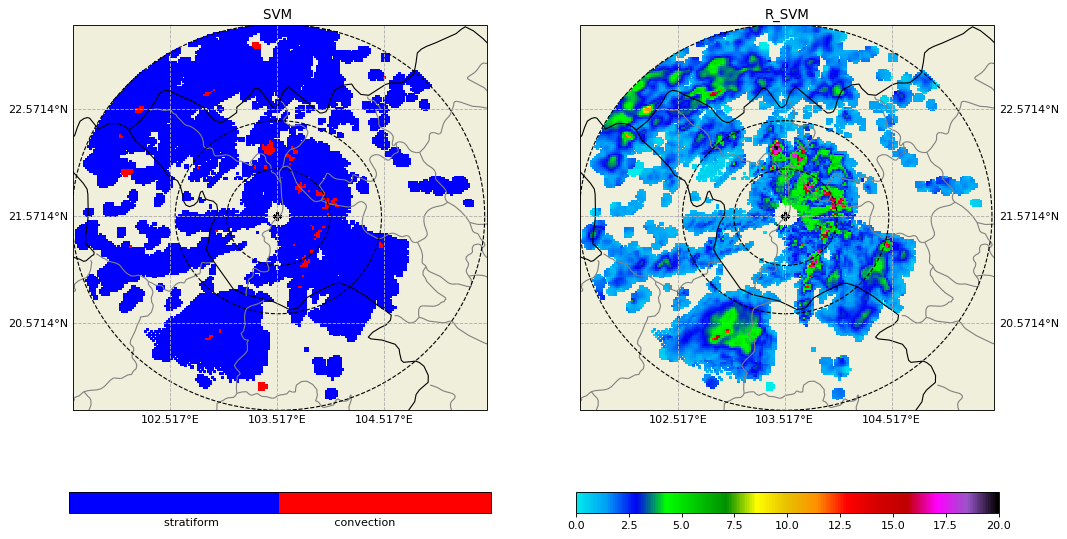

In [252]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
fig=plt.figure(figsize=(15,20),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,CS_SVM,shading='flat',cmap=cMap)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
ax1.set(title="SVM ")
ax1.set_facecolor(color='white')
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',ticks=[], label='stratiform                                 convection');

cmap2=ListedColormap(['white','deepskyblue', 'dodgerblue','blue', 'yellow','orange','red','darkviolet'])
bounds2=[0,1,5,10,20,30,50,80,100]
norm2 = BoundaryNorm(bounds2, cmap2.N)
ticks2  = [1,5,10,20,30,50,80]
ax2=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeat.LAND)
ax2.add_feature(cfeat.OCEAN.with_scale('10m'))
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax2.add_feature(state_provinces_lines,edgecolor='gray')
g2=ax2.gridlines(draw_labels=True,linestyle='--')
g2.xlabels_top = False
g2.ylabels_left = False
g2.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g2.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax2.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax2.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z2_plot=ax2.pcolormesh(lons,lats,R_CS_SVM,shading='flat',cmap=pyart.graph.cm.NWSRef,vmax=20,vmin=0)#,cmap=cmap2,norm=norm2)
ax2.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
ax2.set(title="R_SVM")
plt.colorbar(z2_plot,ax=ax2,orientation='horizontal');#,ticks=ticks2,extend='both');

In [216]:
R_CS_SVM.min()

0.0001950791

In [217]:
R_CS_SVM.max()

22.756653

In [220]:
R_CS_SVM[94,117]

22.756653

In [222]:
indices = np.where(R_CS_SVM == R_CS_SVM.max())
indices

(array([94], dtype=int64), array([117], dtype=int64))

In [223]:
Zh[94,117]

22534.309

In [224]:
ZDR[94,117]

1.4148164

In [225]:
CS_SVM[94,117]

2.0

In [150]:
n=0
for i in range(0,201,1):
    for j in range(0,201,1):
        if data.variables['ZDR_1.5km'][0,i,j] < 10:
            n=n+1
n

16122

In [159]:
data.variables['CS_SVM'][0,90,189]

masked

In [70]:
Zh[132,105]

2.7989812

In [71]:
ZDR[132,105]

13.304543

In [202]:
QPE_dual(Zh[125,27],ZDR[125,27],a=1.2,b=0.23,c=-0.76)

0.26043345043367827

In [226]:
QPE_dual(Zh[94,117],ZDR[94,117],a=3.15,b=0.27,c=-2.1)

22.75665009403505

In [211]:
R_CS_SVM[91,120]

287.8813

In [209]:
n=0
for i in range(0,201,1):
    for j in range(0,201,1):
        if CS_SVM[i,j]==2: #i=y=lat , j=x=lon; i hàng - lat - vi độ, j cột - long - kinh độ , 
            print('---')
            print(i,j)
            n=n+1
            #print(Zh[i,j],ZDR[i,j]
print(n)

---
10 91
---
10 92
---
10 93
---
11 91
---
11 92
---
11 93
---
11 94
---
12 91
---
12 92
---
12 93
---
12 94
---
13 91
---
13 92
---
13 93
---
36 65
---
36 66
---
36 67
---
37 67
---
37 68
---
38 67
---
38 68
---
40 72
---
41 72
---
63 110
---
63 111
---
69 112
---
74 111
---
74 112
---
74 113
---
74 114
---
75 112
---
75 113
---
75 114
---
76 113
---
76 114
---
76 115
---
77 113
---
77 115
---
78 112
---
78 113
---
79 113
---
81 116
---
81 117
---
82 116
---
82 117
---
84 28
---
84 149
---
84 150
---
85 108
---
85 149
---
85 150
---
86 149
---
88 118
---
89 119
---
89 120
---
90 118
---
90 119
---
90 120
---
91 119
---
91 120
---
92 70
---
92 120
---
92 121
---
93 117
---
94 117
---
94 122
---
95 116
---
101 124
---
104 122
---
104 123
---
104 124
---
105 123
---
105 124
---
105 128
---
105 129
---
106 123
---
106 124
---
106 125
---
106 126
---
106 127
---
106 128
---
107 123
---
107 124
---
107 126
---
107 127
---
108 123
---
108 124
---
108 126
---
108 127
---
108 128
---
109 122


In [189]:
a=np.array([[1,2],
        [4,5]])

In [191]:
for i in range(0,2,1):
    for j in range(0,2,1):
        print(a[i,j])

1
2
4
5
